In [32]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import EngFormatter
from scipy.signal import savgol_filter

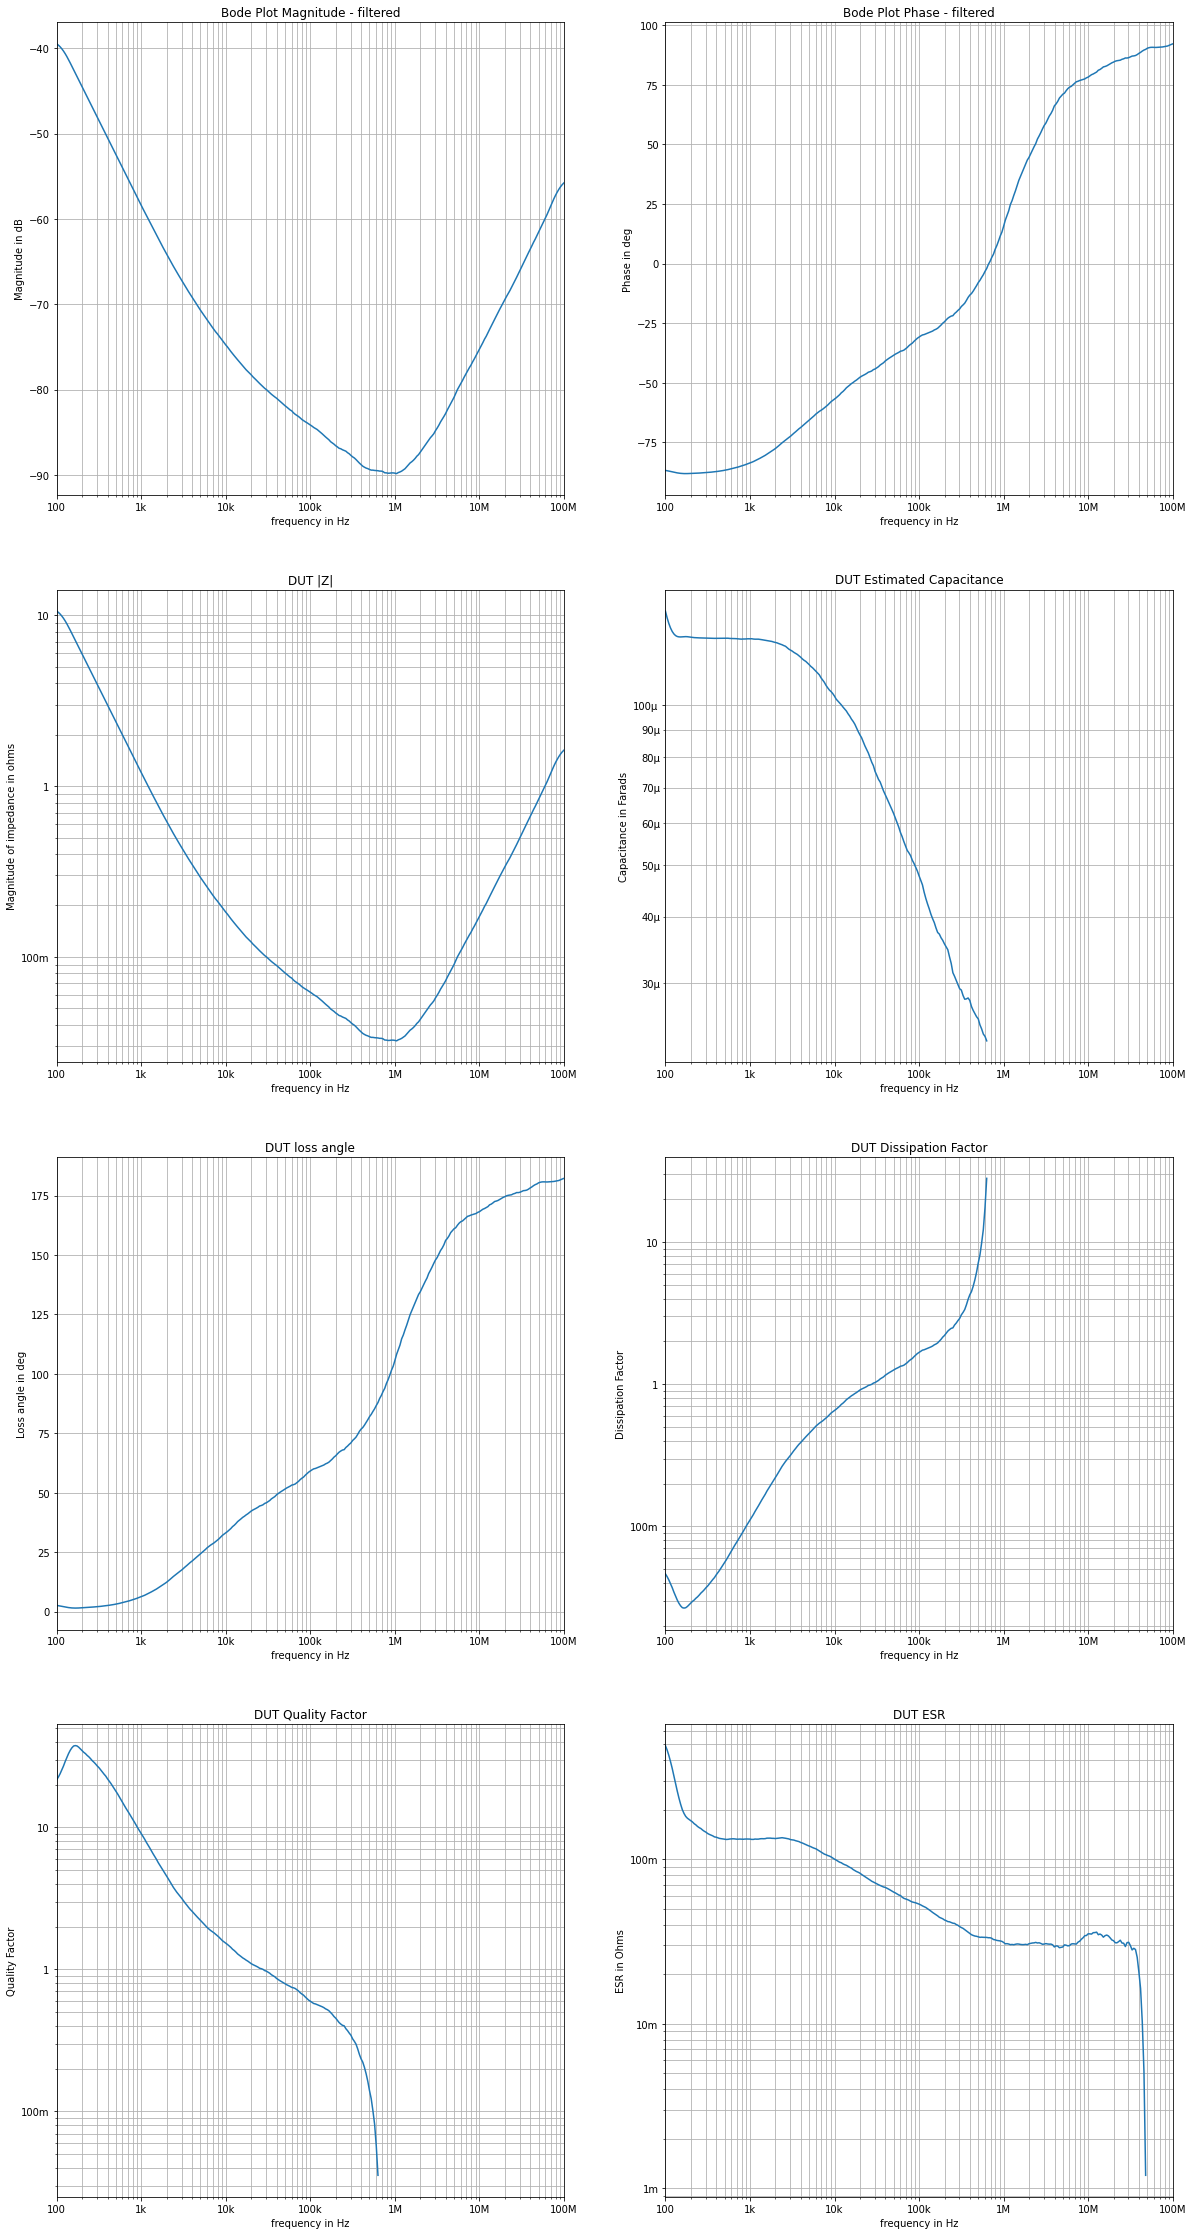

In [106]:
testR = 1000
channel = 'CH3'
fileName = 'SDS2504XHD_Bode_11.csv'

data = pd.read_csv(r'./' + fileName, header = 28)

# Smooth data 
ampSmooth = savgol_filter(data[channel + ' Amplitude(dB)'], 30, 5, mode = 'nearest')
phaSmooth = savgol_filter(data[channel + ' Phase(Deg)'], 30, 5, mode = 'nearest')
Freq = data['Frequency(Hz)']

plt.subplots(figsize=(20, 40))

# Calculate transfer function H(s) of RC circuit based on bode plot magnitude and phase
H = np.power(10, ampSmooth / 20) * np.power(np.e, 1j * (phaSmooth / 360.0 * 2 * np.pi))

# Create array of complex variable s based on frequency points
s = 1j * 2 * np.pi * data['Frequency(Hz)']

# Calculate impedance Z(s) of capacitor as a whole package, including ESR and ESL
Z = H * testR / (1 - H)

# Find the point where the capacitor turns inductive
SRFindex = np.where(np.diff(np.signbit(np.imag(Z))))[0]

# Estimate ESL of capacitor using impedance data past SRF
ESL = Z / s
ESLmean = np.mean(ESL[SRFindex[0] + 1 : -1])

# Calculate ESR(s) of capacitor
ESR = np.real(Z)

# Calculate capacitance C(s) of capacitor, compensating for ESR and estimated mean ESL
C = 1 / (s * (Z - ESR - s * np.real(ESLmean)))

# Calculate loss angle delta(s) of capacitor
delta = np.angle(Z) + np.pi / 2

# Calculate dissipation factor DF(s) of capacitor
df = np.tan(delta)

# Calculate Q(s) of capacitor
Q = 1 / df

plt.subplot(4, 2, 1)
plt.title('Bode Plot Magnitude - filtered')
plt.plot(data['Frequency(Hz)'], ampSmooth)
plt.xscale('log')
plt.xlim(Freq.min(), Freq.max())
plt.grid(True, which="both")
formatter1 = EngFormatter(sep="")
plt.gca().xaxis.set_major_formatter(formatter1)
plt.xlabel('frequency in Hz')
plt.ylabel('Magnitude in dB')

plt.subplot(4, 2, 2)
plt.title('Bode Plot Phase - filtered')
plt.plot(data['Frequency(Hz)'], phaSmooth)
plt.xscale('log')
plt.xlim(Freq.min(), Freq.max())
plt.grid(True, which="both")
formatter1 = EngFormatter(sep="")
plt.gca().xaxis.set_major_formatter(formatter1)
plt.xlabel('frequency in Hz')
plt.ylabel('Phase in deg')

plt.subplot(4, 2, 3)
plt.title('DUT |Z|')
plt.plot(data['Frequency(Hz)'], np.abs(Z))
plt.xscale('log')
plt.yscale('log')
plt.xlim(Freq.min(), Freq.max())
plt.grid(True, which="both")
formatter1 = EngFormatter(sep="")
plt.gca().xaxis.set_major_formatter(formatter1)
plt.gca().yaxis.set_major_formatter(formatter1)
plt.xlabel('frequency in Hz')
plt.ylabel('Magnitude of impedance in ohms')

# Invalidate negative data from plotting
ESR[ESR <= 0] = np.nan
C[C <= 0] = np.nan
df[df <= 0] = np.nan
Q[Q <= 0] = np.nan

# Invalidate data past SRF from plotting
C[SRFindex[0]:-1] = np.nan
df[SRFindex[0]:-1] = np.nan
Q[SRFindex[0]:-1] = np.nan

plt.subplot(4, 2, 4)
plt.title('DUT Estimated Capacitance')
plt.plot(data['Frequency(Hz)'], np.real(C))
plt.xscale('log')
plt.yscale('log')
plt.xlim(Freq.min(), Freq.max())
plt.grid(True, which="both")
formatter1 = EngFormatter(sep="")
plt.gca().xaxis.set_major_formatter(formatter1)
plt.gca().yaxis.set_minor_formatter(formatter1)
plt.gca().yaxis.set_major_formatter(formatter1)
plt.xlabel('frequency in Hz')
plt.ylabel('Capacitance in Farads')

plt.subplot(4, 2, 5)
plt.title('DUT loss angle')
plt.plot(data['Frequency(Hz)'], delta / (2 * np.pi) * 360)
plt.xscale('log')
plt.xlim(Freq.min(), Freq.max())
plt.grid(True, which="both")
formatter1 = EngFormatter(sep="")
plt.gca().xaxis.set_major_formatter(formatter1)
plt.gca().yaxis.set_major_formatter(formatter1)
plt.xlabel('frequency in Hz')
plt.ylabel('Loss angle in deg')

plt.subplot(4, 2, 6)
plt.title('DUT Dissipation Factor')
plt.plot(data['Frequency(Hz)'], df)
plt.xscale('log')
plt.yscale('log')
plt.xlim(Freq.min(), Freq.max())
plt.grid(True, which="both")
formatter1 = EngFormatter(sep="")
plt.gca().xaxis.set_major_formatter(formatter1)
plt.gca().yaxis.set_major_formatter(formatter1)
plt.xlabel('frequency in Hz')
plt.ylabel('Dissipation Factor')

plt.subplot(4, 2, 7)
plt.title('DUT Quality Factor')
plt.plot(data['Frequency(Hz)'], Q)
plt.xscale('log')
plt.yscale('log')
plt.xlim(Freq.min(), Freq.max())
plt.grid(True, which="both")
formatter1 = EngFormatter(sep="")
plt.gca().xaxis.set_major_formatter(formatter1)
plt.gca().yaxis.set_major_formatter(formatter1)
plt.xlabel('frequency in Hz')
plt.ylabel('Quality Factor')

plt.subplot(4, 2, 8)
plt.title('DUT ESR')
plt.plot(data['Frequency(Hz)'], ESR)
plt.xscale('log')
plt.yscale('log')
plt.xlim(Freq.min(), Freq.max())
plt.grid(True, which="both")
formatter1 = EngFormatter(sep="")
plt.gca().xaxis.set_major_formatter(formatter1)
plt.gca().yaxis.set_major_formatter(formatter1)
plt.xlabel('frequency in Hz')
plt.ylabel('ESR in Ohms')

plt.show()
